## Projection onto constrained non-axis-aligned ellipsoid

The nearest non-axis-aligned ellipsoid (parametrized by $(a, b, c, \theta, \phi, \psi)$), with unit volume, to the set of points $\{\mathbf x_i\}$ can be found in the least-squares sense,

$$
\begin{array}{ll}
  \underset{\text {over } a,b,c,\theta,\phi,\psi}{\text{minimize}} & \sum_{i=1}^{m} \left({\mathbf x_i}^\top \mathbf {Q\Lambda Q^\top } \mathbf x_i - 1\right)^2 \\
  \text{subject to} & \frac{4}{3} \pi abc = 1
\end{array}
$$

which can be written in standard form as

$$
\begin{array}{ll}
  \text{minimize} & \| \text{diag}( \mathbf {X^\top Q\Lambda Q^\top X}) - \mathbf{1}_m\|^2 \\
  \text{subject to} & \frac{4}{3} \pi {u_1u_2u_3} = 1
\end{array}
$$

where

$$
\mathbf X = \begin{bmatrix}
  | & \cdots & | \\
  \mathbf x_1 & \cdots & \mathbf x_m \\
  | & \cdots & |
\end{bmatrix}
$$

and $u = \left(a,b,c\right)^\top = \left(1/\sqrt \lambda_1, 1/\sqrt\lambda_2, 1/\sqrt\lambda_3\right)^\top$.


<!-- Note that if $A$ can be decomposed by an eigendecomposition into $A = U^\top  \Lambda U$ where $U$ is an orthonormal rotation matrix and $\Lambda$ is a diagonal matrix of eigenvalues, then it is valid. -->


## Bilevel optimization

Our overall problem can then be stated as

$$
\begin{array}{ll}
  \text{minimize (over $\{(x_i, y_i)\}$)} & 4 \pi \sqrt[p]{\frac{(u_1u_2)^p + (u_1u_3)^p + (u_2u_3)^p}{3}} \\
  \text{subject to} & u^\star = \text{argmin} \; \| \text{diag}(X^\top Q\Lambda Q^\top  X) - \mathbf{1}_m\|^2 \\
  & \hphantom{y =} \text{subject to} \;  \frac{4}{3} \pi {u_1u_2u_3} - 1=0
\end{array}.
$$

In [9]:
import math
import numpy as np
from torch import cos, sin
import scipy.optimize as opt
import torch
import torch.nn as nn
%matplotlib ipympl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# ellipse area and circumferencce
def ellipsoid_volume(a, b,c):
    """Returns the volume of an ellipsoid parametrized as (x/a)^2 + (y/b)^2 + (z/c)^2 = 1."""
    return 4/3 * torch.pi * a * b * c

def ellipsoid_surface_area(a, b, c, p=1.6075):
    """Returns the approximate surface area of an ellipsoid."""
    a_p = a**p
    b_p = b**p
    c_p = c**p
    return 4 * torch.pi * (1/3 * (a_p*b_p + a_p*c_p + b_p*c_p))**(1/p)


def rotation_matrix_3d(angles):
    alpha, beta, gamma = angles[0], angles[1], angles[2] # yaw, pitch, roll
    R = torch.stack([
        torch.stack([cos(alpha)*cos(beta), cos(alpha)*sin(beta)*sin(gamma)-sin(alpha)*cos(gamma), cos(alpha)*sin(beta)*cos(gamma)+sin(alpha)*sin(gamma)]),
        torch.stack([sin(alpha)*cos(beta), sin(alpha)*sin(beta)*sin(gamma)+cos(alpha)*cos(gamma), sin(alpha)*sin(beta)*cos(gamma)-cos(alpha)*sin(gamma)]),
        torch.stack([-sin(beta), cos(beta)*sin(gamma), cos(beta)*cos(gamma)])
    ])
    return R

def generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll):
    phi = 2.0 * math.pi * torch.linspace(0.0, 1.0, sqrt_m).double()
    theta = math.pi * torch.linspace(0.05, 0.95, sqrt_m).double()
    phi, theta = torch.meshgrid(phi, theta)
    x = a * torch.sin(theta) * torch.cos(phi)
    y = b * torch.sin(theta) * torch.sin(phi)
    z = c * torch.cos(theta)
    # Flatten the arrays
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = z.flatten()
    coords = torch.stack((x_flat, y_flat, z_flat), dim=0).double()
    angles = torch.tensor([yaw, pitch, roll], requires_grad=True, dtype=torch.float)
    rotation_matrix = rotation_matrix_3d(torch.deg2rad(angles)).double()
    rotated_coords = rotation_matrix @ coords
    return rotated_coords

def plot_ellipsoid(ax, a, b, c, yaw, pitch, roll, color='blue', linestyle='-', linewidth=0.5, alpha=0.5, sqrt_m=25):
    coords = generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll).T.detach()
    # Reshape the rotated coordinates back to the original shape
    x_rot = coords[:, 0].reshape(sqrt_m,sqrt_m)
    y_rot = coords[:, 1].reshape(sqrt_m,sqrt_m)
    z_rot = coords[:, 2].reshape(sqrt_m,sqrt_m)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')

    ax.plot_wireframe(x_rot.numpy(), y_rot.numpy(), z_rot.numpy(),
                      color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha)
    ax.set_aspect('equal', adjustable='box')

def generate_data(sqrt_m, m, a, b, c, yaw, pitch, roll, nu, p):
    coords = generate_ellipsoid_coords(sqrt_m, a, b, c, yaw, pitch, roll).detach()
    data = coords + nu * torch.randn(3, m, dtype=torch.float)
    data = data.unsqueeze(0)
    return data

def constraint_function(u, p=1.6075):
    # Calculate surface area from parameters
    if not torch.is_tensor(u):
        u = torch.tensor(u)
    # semi axes length method
    a = u[0]
    b = u[1]
    c = u[2]
    res = 4/3 * torch.pi * (a*b*c) - 1
    return res

def constraint_function_grad(u):
    if torch.is_tensor(u):
        u = u.detach().clone()
    else:
        u = torch.tensor(u)
    u.requires_grad = True
    with torch.enable_grad():
        res = constraint_function(u)
    constr_grad = torch.autograd.grad(res, u)[0]
    return constr_grad

def objective_function(u, X):
    if not torch.is_tensor(u):
        u = torch.tensor(u).double()
    if not torch.is_tensor(X):
        X = torch.tensor(X).double()
    L = torch.diag(1/u[:3]**2).double()
    R = rotation_matrix_3d(u[3:6]).double() # assumes radians
    A = R @ L @ R.T
    XT_AX = torch.einsum('ji,jk,ki->i', X, A, X)
    b = torch.ones(X.shape[1])
    return torch.sum((XT_AX - b) ** 2)/100

def objective_function_grad(u, X):
    if torch.is_tensor(u):
        u = u.detach().clone()
    else:
        u = torch.tensor(u)
    if torch.is_tensor(X):
        X = X.detach().clone()
    else:
        X = torch.tensor(X).double()
    u.requires_grad = True
    with torch.enable_grad():
        res = objective_function(u, X).double()
    obj_grad = torch.autograd.grad(res, u)[0].double()
    return obj_grad

# ellipse fitting
def fit_ellipsoid(xs, p, method="default", with_jac=False):
    """Find ellipsoid parameters u = (1/a^2, 1/b^2, 1/c^2) that best fit the data."""
    n_batches = xs.size(0)
    results = torch.zeros(n_batches, 6, dtype=torch.double)
    for batch_number, x in enumerate(xs):
        X = x.detach().numpy()
        u0 = initialise_u(X, method)
        if with_jac:
            eq_const = {'type': 'eq',
                        'fun' : lambda u: constraint_function(u).cpu().numpy(),
                        'jac' : lambda u: constraint_function_grad(u).cpu().numpy()
                        }
            ineq_const = {'type': 'ineq',
                        'fun' : lambda u: np.array([np.pi - u[3], np.pi - u[4],np.pi - u[5], u[3], u[4], u[5]])}
            res = opt.minimize(lambda u: objective_function(u, X).detach().cpu().numpy(), u0, jac=lambda u: objective_function_grad(u,X).cpu().numpy(), 
                            method='SLSQP', constraints=[eq_const, ineq_const],
                            options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
        else:
            eq_const = {'type': 'eq',
                        'fun' : lambda u: constraint_function(u).cpu().numpy(),
                        }
            ineq_const = {'type': 'ineq',
                        'fun' : lambda u: np.array([np.pi - u[3], np.pi - u[4],np.pi - u[5], u[3], u[4], u[5]])}
            res = opt.minimize(lambda u: objective_function(u, X).detach().cpu().numpy(), u0,
                            method='SLSQP', constraints=[eq_const, ineq_const],
                            options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
        if not res.success:
            print("FIT failed:", res.message)
        results[batch_number] = torch.tensor(res.x, dtype=torch.double, requires_grad=True)
    return results


def initialise_u(data, method):
    if method == "default": # random initialisation
        u0 = np.ones(6)
    elif method == "bb":
        h,w,l = get_bounding_box_dims(data)/2
        u0 = np.zeros(6)
        u0[:3] = np.array([h,w,l])
        u0[3:] = np.random.uniform(low=0, high=90, size=3)
    elif method == "pca":
        u0 = pca(data)
    return u0

def get_angles(rotation):
    pitch = - np.arcsin(rotation[2,0])
    denom = 1/np.sqrt(1 - (rotation[2,0] ** 2))
    roll = np.arctan2(rotation[2,1]/denom, rotation[2,2]/denom)
    yaw = np.arctan2(rotation[1,0]/denom, rotation[0,0]/denom)
    return np.rad2deg([yaw, pitch, roll])

def pca(data):
    """
    Get three dominant axes of data along with angles
    """
    data = data.T
    pca = PCA(n_components=3)
    pca.fit(data)
    semiaxes = np.sqrt(pca.explained_variance_ * np.array([2,4,4]))
    rotation = np.fliplr(pca.components_)
    angles = np.array(get_angles(rotation))
    u0 = np.concatenate([semiaxes, angles])
    return u0
    
def extract_params(u):
    if torch.any(u) < 0:
        print("WARNING: Negative axes lengths.")
    a, b, c = (torch.abs(u[:3])).tolist()
    yaw, pitch, roll = np.rad2deg(u[3:].tolist()) % 360
    return a,b,c,yaw,pitch,roll

def get_bounding_box_dims(points):
    min_x, min_y, min_z = np.min(points, axis=1)
    max_x, max_y, max_z = np.max(points, axis=1)

    # Calculate the dimensions of the bounding box
    height = max_z - min_z
    width = max_x - min_x
    length = max_y - min_y
    return np.sort([height, width, length])

def plot_points(ax, data, color, alpha):
    x,y,z = data[0,0:3].detach().numpy()
    ax.scatter(x,y,z, color=color, alpha=alpha, s=1)

def inner_problem(semiaxes, angles, sqrt_m, nu, p, method="default", with_jac=False):
    m = sqrt_m * sqrt_m
    if method=="pca":
        sorted_params = sorted(zip(semiaxes, angles), key=lambda u: u[0])
        semiaxes, angles = zip(*sorted_params)
    a, b, c = semiaxes
    yaw, pitch, roll = np.array(angles)
    print(f"Ellipsoid (blue) ({a:0.3}, {b:0.3}, {c:0.3}, {float(yaw):0.3}\N{DEGREE SIGN}, {float(pitch):0.3}\N{DEGREE SIGN}, {float(roll):0.3}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a, b, c):0.3} and surface area {ellipsoid_surface_area(a, b, c, p):0.3}")

    data = generate_data(sqrt_m, m, a, b, c, yaw, pitch, roll, nu, p)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_ellipsoid(ax, a, b, c, yaw, pitch, roll, color='b')
    plot_points(ax, data, 'b', 0.8)

    # Fit the ellipse to the data
    u = fit_ellipsoid(data, p, method, with_jac).squeeze()
    a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat = extract_params(u.detach())
    plot_ellipsoid(ax, a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat, color='r')
    print(f"Ellipsoid (red) ({a_hat:0.3}, {b_hat:0.3}, {c_hat:0.3}, {(yaw_hat):0.4}\N{DEGREE SIGN}, {(pitch_hat):0.4}\N{DEGREE SIGN}, {(roll_hat):0.4}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a_hat, b_hat, c_hat):0.3} and surface area {ellipsoid_surface_area(a_hat, b_hat, c_hat, p):0.3}")
    plt.show()

    return m, data

[0.45, 0.45, 0.7]
Ellipsoid (blue) (0.45, 0.45, 0.7, 20.0°, 40.0°, 50.0°) has volume 0.594 and surface area 3.53
Ellipsoid (red) (0.772, 0.456, 0.679, 74.96°, 1.042e-15°, 57.65°) has volume 1.0 and surface area 5.05


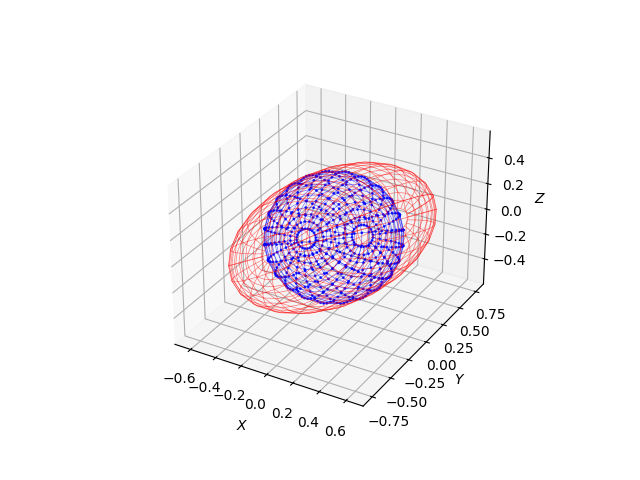

In [10]:
# sample a noisy ellipse
sqrt_m = 25
a, b, c = 0.45,0.45,0.7
yaw, pitch, roll = 30.0, 25., -120.
print([a,b,c])

yaw, pitch, roll = 20,40,50

nu = 1.0e-4
p = 1.6075

m, data = inner_problem((a,b,c), (yaw,pitch,roll), sqrt_m, nu, p, method="default", with_jac=True)

Theoretical min surface area is 4.835975862043171
    0 ellipsoid estimate (0.772, 0.456, 0.679, 74.96°, 1.451e-15°, 57.65°) has volume 1.0 and surface area 5.05. LR 0.12
    1 ellipsoid estimate (0.447, 0.779, 0.685, 32.81°, 25.58°, 54.55°) has volume 1.0 and surface area 5.07. LR 0.12
    2 ellipsoid estimate (0.457, 0.76, 0.688, 3.022°, 51.96°, 36.54°) has volume 1.0 and surface area 5.04. LR 0.12
    3 ellipsoid estimate (0.495, 0.691, 0.698, 16.13°, 43.94°, 122.3°) has volume 1.0 and surface area 4.94. LR 0.12
    4 ellipsoid estimate (0.504, 0.689, 0.688, 28.35°, 31.79°, 47.07°) has volume 1.0 and surface area 4.92. LR 0.12
    5 ellipsoid estimate (0.501, 0.696, 0.685, 40.35°, 14.1°, 48.31°) has volume 1.0 and surface area 4.93. LR 0.12
    6 ellipsoid estimate (0.507, 0.693, 0.679, 25.3°, 35.28°, 47.98°) has volume 1.0 and surface area 4.92. LR 0.12
    7 ellipsoid estimate (0.474, 0.746, 0.676, -4.117e-15°, 55.67°, 32.62°) has volume 1.0 and surface area 4.99. LR 0.12
    8 el

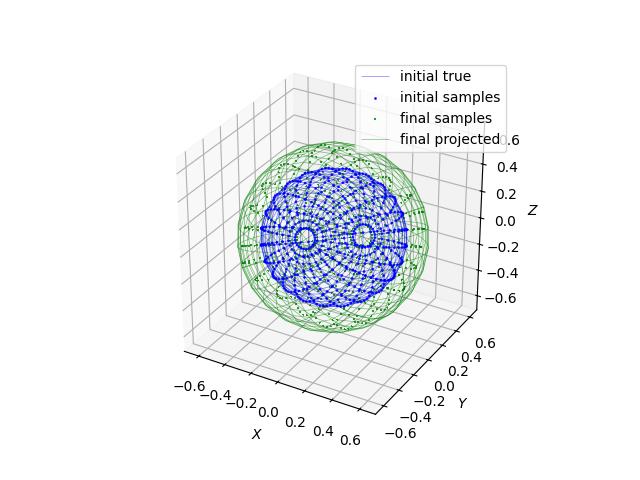

In [11]:
# set correct location for DDN repository code and import basic node functionality
import sys
sys.path.append("../../../ddn/")
from ddn.pytorch.node import *
    
torch.autograd.set_detect_anomaly(True)


class EllipsoidConstrainedProjectionNode(EqConstDeclarativeNode):
    """A DDN node for the constrained ellipse projection problem. Gradients will be calculated automatically."""

    def __init__(self, m):
        super().__init__(eps=1.0e-4) # relax tolerance on optimality test 
        # make sure node is properly constructed
        self.n = tuple([3 * m]) # coordinate dimension x number of points
        self.m = m # number of points
        
    def objective(self, xs, y):
        # xs: tensor of shape (batch_size, 3 * m)
        # y: tensor of shape (batch_size, 6)
        n_batches = xs.size(0)
        data = xs.view(n_batches, 3, -1) # shape: (batch_size, 3, m)
        # Reshape y to (batch_size, 6, 1) for L_diag and angles extraction
        y = y.view(n_batches, 6, 1)
        # Extract L_diag and angles from y
        L_diag = y[:, :3, :].squeeze(2)  # shape: (batch_size, 3)
        L_diag = 1/L_diag**2
        angles = y[:, 3:, :]   # shape: (batch_size, 3, 1)
        # Compute L matrix for all batches
        L = torch.diag_embed(L_diag).double()  # shape: (batch_size, 3, 3)
        # Vectorized computation of R matrix for all batches
        angles = angles.squeeze(2)  # shape: (batch_size, 3)
        cos_angles = torch.cos(angles)
        sin_angles = torch.sin(angles)
        # Construct the rotation matrix R for all batches
        R = torch.zeros((n_batches, 3, 3), dtype=torch.double, device=xs.device)
        cos_yaw, cos_pitch, cos_roll = cos_angles[:, 0], cos_angles[:, 1], cos_angles[:, 2]
        sin_yaw, sin_pitch, sin_roll = sin_angles[:, 0], sin_angles[:, 1], sin_angles[:, 2]
        R[:, 0, 0] = cos_yaw * cos_pitch
        R[:, 0, 1] = cos_yaw * sin_pitch * sin_roll - sin_yaw * cos_roll
        R[:, 0, 2] = cos_yaw * sin_pitch * cos_roll + sin_yaw * sin_roll
        R[:, 1, 0] = sin_yaw * cos_pitch
        R[:, 1, 1] = sin_yaw * sin_pitch * sin_roll + cos_yaw * cos_roll
        R[:, 1, 2] = sin_yaw * sin_pitch * cos_roll - cos_yaw * sin_roll
        R[:, 2, 0] = -sin_pitch
        R[:, 2, 1] = cos_pitch * sin_roll
        R[:, 2, 2] = cos_pitch * cos_roll
        # Compute A matrix for all batches
        A = torch.bmm(R, torch.bmm(L, R.transpose(1, 2)))  # shape: (batch_size, 3, 3)
        # Compute XT_AX for all batches using torch.einsum
        XT_AX = torch.einsum('bji,bjk,bki->bi', data, A, data)  # shape: (batch_size, m)
        # Compute b tensor for all batches
        obj_val = torch.sum((XT_AX - b).pow(2), dim=1)
        # print("Objective value:", obj_val)
        if torch.isnan(obj_val).any():
            raise ValueError("NaNs detected in objective function")
        return obj_val

    
    def equality_constraints(self, xs, y):
        # y is of shape [m x number of parameters] (same as u)

        # # inverse squared method
        # u = 1/y[:,:3]**2
        # u1 = u[:,0]
        # u2 = u[:,1]
        # u3 = u[:,2]
        # # Compute the components of the constraint
        # term1 = (1 / torch.sqrt(u1 * u2)) ** p
        # term2 = (1 / torch.sqrt(u1 * u3)) ** p
        # term3 = (1 / torch.sqrt(u2 * u3)) ** p
        # # Calculate the average and constraint value
        # average = (1/3) * (term1 + term2 + term3)
        # constraint_val = 4 * math.pi * (average ** (1 / p)) - 1      
  
        # normal method
        a = y[:,0]
        b = y[:,1]
        c = y[:,2]

        constraint_val = 4/3 * torch.pi * a * b * c - 1


        if torch.isnan(constraint_val).any():
            raise ValueError("NaNs detected in equality constraints")
        return constraint_val


    def solve(self, xs, method="default", with_jac=False):
        # process batches independently
        n_batches = xs.size(0)
        results = torch.zeros(n_batches, 6, dtype=torch.double)
        for batch_number, x in enumerate(xs):
            assert(len(x) == self.n[0])
            X = x.reshape(3, -1).detach().numpy()
            u0 = initialise_u(X, method)
            if with_jac:
                eq_const = {'type': 'eq',
                            'fun' : lambda u: constraint_function(u).cpu().numpy(),
                            'jac' : lambda u: constraint_function_grad(u).cpu().numpy()
                            }
                ineq_const = {'type': 'ineq',
                            'fun' : lambda u: np.array([np.pi - u[3], np.pi - u[4],np.pi - u[5], u[3], u[4], u[5]])}
                res = opt.minimize(lambda u: objective_function(u, X).detach().cpu().numpy(), u0, jac=lambda u: objective_function_grad(u,X).cpu().numpy(), 
                                method='SLSQP', constraints=[eq_const, ineq_const],
                                options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
            else:
                eq_const = {'type': 'eq',
                            'fun' : lambda u: constraint_function(u).cpu().numpy(),
                            }
                ineq_const = {'type': 'ineq',
                            'fun' : lambda u: np.array([np.pi - u[3], np.pi - u[4],np.pi - u[5], u[3], u[4], u[5]])}
                res = opt.minimize(lambda u: objective_function(u, X).detach().cpu().numpy(), u0,
                                method='SLSQP', constraints=[eq_const, ineq_const],
                                options={'ftol': 1e-9, 'disp': False, 'maxiter': 200})
            if not res.success:
                print("SOLVE failed:", res.message)
            results[batch_number] = torch.tensor(res.x, dtype=torch.float32, requires_grad=True)
        return results, None


class EllipseConstrainedProjectionFunction(DeclarativeFunction):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

class SurfaceAreaLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, p=1.6075):
        u1_p = input[:,0] 
        u2_p = input[:,1] 
        u3_p = input[:,2] 
        res = 40 * (((u1_p*u2_p)**p + (u1_p*u3_p)**p + (u2_p*u3_p)**p)) ** (1/p)
        return res

def outer_problem(n_pts, data, n_iters=20, lr=0.1, method="default", with_jac=False):
    node = EllipsoidConstrainedProjectionNode(n_pts)

    n_batches = data.size(0)
    x_init = data.view(n_batches, -1)
    x_init.requires_grad = True
    y_init, _ = node.solve(x_init)
    y_init = EllipseConstrainedProjectionFunction.apply(node, x_init)
    surf_area_loss = SurfaceAreaLoss()
    history = [y_init]
    x = x_init.clone().detach().requires_grad_(True)
    torch_opt = torch.optim.SGD([x], lr=lr)
    lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(torch_opt, factor=0.9, patience=20, cooldown=0)
    print("Theoretical min surface area is", 4*np.pi*(.620350490899**2))

    for i in range(n_iters):
        torch_opt.zero_grad(set_to_none=True)
        y = EllipseConstrainedProjectionFunction.apply(node, x)
        history.append(y.detach().clone())
        if True:
            u = fit_ellipsoid(x.view(n_batches, 3, -1), p, method=method, with_jac=with_jac)
            a_hat = abs(u[:,0].item())
            b_hat = abs(u[:,1].item())
            c_hat = abs(u[:,2].item())
            yaw_hat, pitch_hat, roll_hat = np.rad2deg(u[:,3:6].squeeze().tolist())
            print(f"{i:5d} ellipsoid estimate ({a_hat:0.3}, {b_hat:0.3}, {c_hat:0.3}, {yaw_hat:0.4}\N{DEGREE SIGN}, {pitch_hat:0.4}\N{DEGREE SIGN}, {roll_hat:0.4}\N{DEGREE SIGN}) has volume {ellipsoid_volume(a_hat, b_hat, c_hat):0.3} and surface area {ellipsoid_surface_area(a_hat, b_hat, c_hat, p):0.3}. LR {torch_opt.param_groups[0]['lr']}")
        loss = surf_area_loss(y)
        loss.backward()
        torch_opt.step()
        lr_sched.step(loss.item())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_ellipsoid(ax, a, b, c, yaw, pitch, roll, color='blue')
    ax.scatter(data[0, 0].numpy(), data[0, 1].numpy(), data[0, 2].numpy(), color='b', alpha=0.8, s=1)

    final_data = x.reshape(1, 3, -1).detach()
    ax.scatter(final_data[0, 0].numpy(), final_data[0, 1].numpy(), final_data[0, 2].numpy(), color='g', marker='+', alpha=0.8, s=1)

    u = fit_ellipsoid(final_data, p, method=method, with_jac=with_jac)
    a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat = extract_params(u.squeeze().detach())
    plot_ellipsoid(ax, a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat, color='green')

    print("Final ellipsoid ({:0.10}, {:0.10}, {:0.10}, {:0.10}, {:0.10}, {:0.10}) has volume {:0.3} and surface area {:0.6}.".format(a_hat, b_hat, c_hat, yaw_hat, pitch_hat, roll_hat, ellipsoid_volume(a_hat, b_hat, c_hat), ellipsoid_surface_area(a_hat, b_hat, c_hat, p)))
    plt.legend(['initial true', 'initial samples', 'final samples', 'final projected'])
    plt.show()


outer_problem(m, data, n_iters=50, with_jac=False, lr=0.12)